See: http://nipy.org/dipy/examples_built/affine_registration_3d.html

In [1]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [3]:
import nibabel as nib

In [4]:
func_img = nib.load('ds114_sub009_t2r1.nii')
mean_data = func_img.get_data()[..., 4:].mean(axis=-1)
mean_affine = func_img.affine

In [5]:
source_img = nib.load('ds114_sub009_highres_brain.nii')
source_data = source_img.get_data()
source_affine = source_img.affine
target_data = mean_data
target_affine = func_img.affine

Disturb the registration again

In [6]:
source_affine[0, -1] += 10

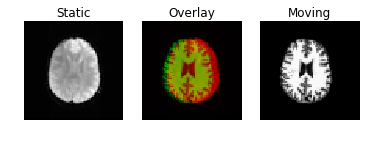

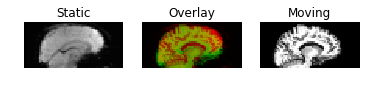

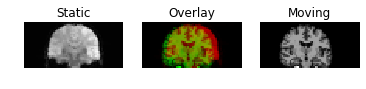

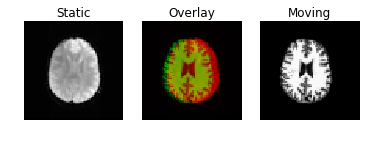

In [7]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       target_data.shape, target_affine,
                       source_data.shape, source_affine)
resampled = affine_map.transform(source_data)
regtools.overlay_slices(target_data, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(target_data, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(target_data, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

In [8]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [9]:
level_iters = [10000, 1000, 100]

In [10]:
sigmas = [3.0, 1.0, 0.0]

In [11]:
factors = [4, 2, 1]

In [12]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [13]:
transform = TranslationTransform3D()
params0 = None
translation = affreg.optimize(target_data, source_data, transform, params0,
                              target_affine, source_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [14]:
translation.affine

array([[  1.    ,   0.    ,   0.    ,  12.0894],
       [  0.    ,   1.    ,   0.    ,  -2.4918],
       [  0.    ,   0.    ,   1.    ,  -5.7955],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

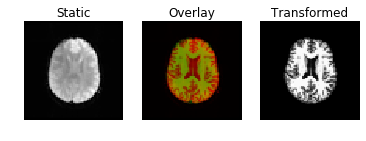

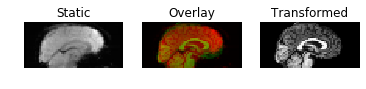

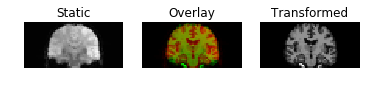

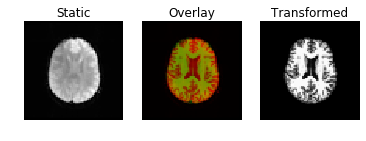

In [15]:
transformed = translation.transform(source_data)
regtools.overlay_slices(target_data, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(target_data, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(target_data, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

In [16]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(target_data, source_data, transform, params0,
                        target_affine, source_affine,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [17]:
rigid.affine

array([[  0.9999,  -0.0121,   0.0058,  12.5687],
       [  0.012 ,   0.9999,   0.0089,  -2.9371],
       [ -0.0059,  -0.0088,   0.9999,  -5.4699],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

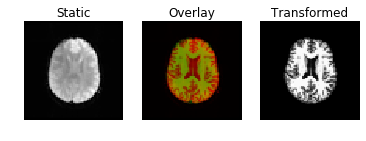

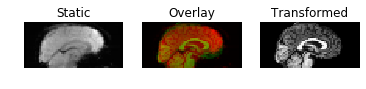

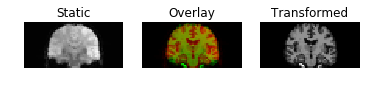

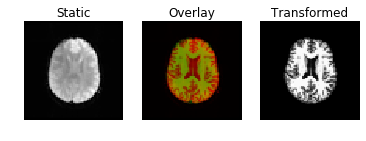

In [18]:
transformed = translation.transform(source_data)
regtools.overlay_slices(target_data, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(target_data, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(target_data, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")